# Titanic Survival Classification - Gradient Boosting and Autoencoding (Part 8)

So the next primary methodologies I wish to learn more about are Gradient Boosting, so as building a decision tree from scratch was incredibly useful.  So now I wish to build a Gradient Boosting algorithm from scratch to gain greater insight into how they work.

## Building a Gradient Boosting Machine

So my sources for learning Gradient boosting are as follows - 

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

From my understanding this is a technique for effectively ensembling other ML algorithms by recursively fitting the residuals of the previous algorithm.

This seems like a relatively straightforward series of steps - 

1. Train initial model
2. Calculate initial residuals - ie $ R_1 = {y} - \hat{y_1}$
3. Train new model on residuals $R$ as this model's y vector
4. Calculate new final y output as $\hat{y_2} = \hat{y_1} + R_1$
5. Iterate steps 2 through 4 as many times as necessary as $\hat{y_{n+1}} = \hat{y_n} + R_n$

With this frameworks multiple models of either the same or differing algorithms/architectures can be used as a way of ensembling models.  

In [1]:
#First importing some relevant packages
import numpy as np
import pandas as pd

#Stop pandas from truncating output view
pd.options.display.max_columns = None

#Import Tensorflow
import tensorflow as tf

#Import Keras
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras import regularizers
from keras.optimizers import Adam, SGD

#Import mathematical functions
from random import *
import math
import matplotlib
import matplotlib.pyplot as plt

#Get regular expression package
import re

#Import  Scikit learn framework
import sklearn as sk
from sklearn import svm
from sklearn import linear_model

F:\anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import the functions built in previous parts
from Titanic_Import import *

full_set = pd.read_csv('D:/Datasets/Titanic/train.csv')
sub_set = pd.read_csv('D:/Datasets/Titanic/test.csv')

In [3]:
append_set = full_set
append_set = append_set.append([sub_set], ignore_index =True )
clean_set = Cleanse_Data_v3(append_set)
X_Train, Y_Train, X_CV, Y_CV, X_Test = dataset_splitter(clean_set, cv_size = 200)

For simplicity I will import the linear regression model from SciKit learn, although in principle any model that can perform linear and logistic regression should work for gradient boosting.

In [5]:
logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X_Train, Y_Train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [42]:
y_hat_probs = logreg.predict_proba(X_Train)
y_hat_cv_probs = logreg.predict_proba(X_CV)

y_hat =  normalize_predictions(y_hat_probs[:, 1])
y_hat_cv = normalize_predictions(y_hat_cv_probs[:, 1])

In [43]:
acc5, score5, conf5 = Calc_Accuracy(Y_Train, y_hat)

print("Accuracy = ", acc5)
print("F1 Score = ", score5)
print("")
print("Confusion Matrix")
conf5[["Labels", "Actual True", "Actual False"]]

Accuracy =  83.79160636758321
F1 Score =  0.7878787878787878

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,208.0,54.0
1,Pred False,58.0,371.0


In [44]:
acc5, score5, conf5 = Calc_Accuracy(Y_CV, y_hat_cv)

print("Accuracy = ", acc5)
print("F1 Score = ", score5)
print("")
print("Confusion Matrix")
conf5[["Labels", "Actual True", "Actual False"]]

Accuracy =  86.5
F1 Score =  0.8280254777070064

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,65.0,16.0
1,Pred False,11.0,108.0


So this seems to work reasonably well, so it seems like a solid start to building a gradient boosting model, the first model will be a logistic regression model as above.  Every subsequent model will then be a SVM regression model to predict the residuals.

In [166]:
class Gradboost_Mach(object):
    def __init__(self, num_models, C = 1e5, max_iter = 100):
        self.num_models = num_models
        self.models = {}
        for i in range(num_models) :
            if i == 0 :
                self.models['mod' + str(i)] = linear_model.LogisticRegression(C = C, max_iter = max_iter)
            else :
                self.models['mod' + str(i)] = svm.SVR(kernel= 'rbf')
    
    def Train_models(self, X_in, Y_in, print_cost = False):
        Y_out1 = np.zeros((Y_in.shape[0], 2))
        Y_out2 = np.zeros(Y_in.shape)
        Y_vec = {}
        Residuals = {}
        for i in range(self.num_models):
            Residuals['R_' + str(i)] = np.zeros(Y_in.shape)
            if i == 0 :
                self.models['mod' + str(i)].fit(X_in, Y_in)
                Y_out1 = self.models['mod' + str(i)].predict_proba(X_in)
                Y_vec['Y_' + str(i)] = Y_out1[:, 1]
                Residuals['R_' + str(i)] = Y_Train - Y_out1[:, 1]
                if print_cost == True :
                    Cost = sum(np.square(Residuals['R_' + str(i)]))
                    print('Cost' + repr(i) + ' = ' + repr(Cost))
            else :
                Fit_R = Residuals['R_' + str(i - 1)]
                self.models['mod' + str(i)].fit(X_in, Fit_R)
                Y_out2 = self.models['mod' + str(i)].predict(X_in)
                Y_vec['Y_' + str(i)] = Y_vec['Y_' + str(i - 1)] + Y_out2
                Residuals['R_' + str(i)] = Y_Train - Y_vec['Y_' + str(i)]
                
                if print_cost == True :
                    Cost = sum(np.square(Residuals['R_' + str(i)]))
                    print('Cost' + repr(i) + ' = ' + repr(Cost))
        
            if i == (self.num_models - 1) :
                Cost = np.square(Residuals['R_' + str(i)])
                return(sum(Cost))
            
    def Predict(self, X_in):
        Y_mat = np.zeros((X_in.shape[0], self.num_models))
        
        Y_out1 = np.zeros((X_in.shape[0], 2))
        Y_out2 = np.zeros((X_in.shape[0],))
        
        for i in range(self.num_models):
            if i == 0 :
                Y_out1 = self.models['mod' + str(i)].predict_proba(X_in)
                Y_mat[:, 0] = Y_out1[:, 1]
            else :
                Y_out2 = self.models['mod' + str(i)].predict(X_in)
                Y_mat[:, i] = Y_out2
        
        Y_hat = sum(Y_mat.T)
        return(Y_hat)

In [208]:
test_gb = Gradboost_Mach(5000)

In [209]:
cost = test_gb.Train_models(X_Train, Y_Train, True)

Cost0 = 87.92865952304959
Cost1 = 90.4744950734984
Cost2 = 87.70498111702356
Cost3 = 85.61755209853388
Cost4 = 83.98881812717252
Cost5 = 83.0019243835363
Cost6 = 82.51315991667212
Cost7 = 82.24552506033704
Cost8 = 81.97716104803071
Cost9 = 81.62903814225024
Cost10 = 81.38150571039424
Cost11 = 81.30926023001815
Cost12 = 81.13242825607892
Cost13 = 81.01977639217549
Cost14 = 80.84814940947396
Cost15 = 80.67313447187216
Cost16 = 80.44432627133946
Cost17 = 80.25963559144164
Cost18 = 80.08487951065705
Cost19 = 79.93956085888048
Cost20 = 79.77206679937129
Cost21 = 79.61006242006653
Cost22 = 79.48575075383445
Cost23 = 79.37258964762302
Cost24 = 79.26759740287481
Cost25 = 79.18222910018264
Cost26 = 79.07739076000472
Cost27 = 78.92899622775732
Cost28 = 78.78947460867097
Cost29 = 78.66287874919408
Cost30 = 78.51929464224283
Cost31 = 78.40608623861706
Cost32 = 78.2836686741221
Cost33 = 78.15418825752234
Cost34 = 78.04790894013358
Cost35 = 77.93790880157076
Cost36 = 77.83786897481477
Cost37 = 77.73

Cost300 = 70.09358497569525
Cost301 = 70.07977897814355
Cost302 = 70.07471203639832
Cost303 = 70.05757846565517
Cost304 = 70.05472931836687
Cost305 = 70.05127584542203
Cost306 = 70.03713996372207
Cost307 = 70.03485552278268
Cost308 = 70.02506185445027
Cost309 = 70.02070563434214
Cost310 = 70.0084136885788
Cost311 = 70.0045028059789
Cost312 = 69.99367919566845
Cost313 = 69.98904115845909
Cost314 = 69.97861863660289
Cost315 = 69.97694324982793
Cost316 = 69.97037072829553
Cost317 = 69.96304017857669
Cost318 = 69.95883205778233
Cost319 = 69.95170586687784
Cost320 = 69.94215627715494
Cost321 = 69.93571756539555
Cost322 = 69.93527216181757
Cost323 = 69.92759178392494
Cost324 = 69.92317689634065
Cost325 = 69.9150052836755
Cost326 = 69.9118405219583
Cost327 = 69.90559585474344
Cost328 = 69.8977398289078
Cost329 = 69.8908147264205
Cost330 = 69.88316175116366
Cost331 = 69.88086373237627
Cost332 = 69.87477637991815
Cost333 = 69.87046800197245
Cost334 = 69.86169014854931
Cost335 = 69.8564004177504

Cost597 = 68.6442830940107
Cost598 = 68.64283428841584
Cost599 = 68.63517159908851
Cost600 = 68.62748697008831
Cost601 = 68.62935768470503
Cost602 = 68.62924261568568
Cost603 = 68.62072568908029
Cost604 = 68.6168080602314
Cost605 = 68.61339632109083
Cost606 = 68.61114349486746
Cost607 = 68.60592962601095
Cost608 = 68.5997685465876
Cost609 = 68.59878327076505
Cost610 = 68.5964866861469
Cost611 = 68.5879754369437
Cost612 = 68.58878762433947
Cost613 = 68.58343657852119
Cost614 = 68.57513338221123
Cost615 = 68.57163205287107
Cost616 = 68.5724813161223
Cost617 = 68.5622761530038
Cost618 = 68.56015775100606
Cost619 = 68.55712434279344
Cost620 = 68.543286278423
Cost621 = 68.5482015611161
Cost622 = 68.54524583195354
Cost623 = 68.53808675371204
Cost624 = 68.53048355065071
Cost625 = 68.52088589079732
Cost626 = 68.51887164815919
Cost627 = 68.51649685046982
Cost628 = 68.51092946676619
Cost629 = 68.50485522219985
Cost630 = 68.5012567066731
Cost631 = 68.49399246336306
Cost632 = 68.49563524790742
Cos

Cost893 = 67.70503095839571
Cost894 = 67.71055978713201
Cost895 = 67.7026730095712
Cost896 = 67.70628886264343
Cost897 = 67.70232114736474
Cost898 = 67.69819594141387
Cost899 = 67.69657960675387
Cost900 = 67.69391487331728
Cost901 = 67.69531335303319
Cost902 = 67.68901836219398
Cost903 = 67.69077606586106
Cost904 = 67.68732066985278
Cost905 = 67.68400213017009
Cost906 = 67.68705219442099
Cost907 = 67.68097214755464
Cost908 = 67.67600517909763
Cost909 = 67.68028999649269
Cost910 = 67.6711948131373
Cost911 = 67.6780455171605
Cost912 = 67.67506290563003
Cost913 = 67.67274305693631
Cost914 = 67.66272272733437
Cost915 = 67.66565651402374
Cost916 = 67.66300715404488
Cost917 = 67.65506417286352
Cost918 = 67.66185868656807
Cost919 = 67.65934330564515
Cost920 = 67.65097064724198
Cost921 = 67.65139156776878
Cost922 = 67.65480544626827
Cost923 = 67.6418330086496
Cost924 = 67.64429437735875
Cost925 = 67.64251672904035
Cost926 = 67.6409393970556
Cost927 = 67.63844263993165
Cost928 = 67.635192623273

Cost1188 = 67.19816512594664
Cost1189 = 67.20461831915492
Cost1190 = 67.19898407922453
Cost1191 = 67.19655073987745
Cost1192 = 67.19724442460702
Cost1193 = 67.19011307927491
Cost1194 = 67.19626657409721
Cost1195 = 67.1898877118277
Cost1196 = 67.192477065275
Cost1197 = 67.18868208991235
Cost1198 = 67.18761429664863
Cost1199 = 67.18634801791461
Cost1200 = 67.1891794864402
Cost1201 = 67.18225178302163
Cost1202 = 67.179264297538
Cost1203 = 67.18327458662664
Cost1204 = 67.17381159166526
Cost1205 = 67.17472256002725
Cost1206 = 67.16915148249007
Cost1207 = 67.16994082914238
Cost1208 = 67.1668830727997
Cost1209 = 67.1655571710653
Cost1210 = 67.16361911504693
Cost1211 = 67.16293700379597
Cost1212 = 67.16585048008073
Cost1213 = 67.16087585631303
Cost1214 = 67.16363852310954
Cost1215 = 67.16075749651384
Cost1216 = 67.15639752593957
Cost1217 = 67.1567636529664
Cost1218 = 67.15764507613285
Cost1219 = 67.15564746166008
Cost1220 = 67.1589899090459
Cost1221 = 67.15018151581376
Cost1222 = 67.1533937302

Cost1476 = 67.0127149512676
Cost1477 = 67.01344278229448
Cost1478 = 67.01439005351511
Cost1479 = 67.01769979235753
Cost1480 = 67.01400427321622
Cost1481 = 67.01489361343432
Cost1482 = 67.01922960032753
Cost1483 = 67.01323516970129
Cost1484 = 67.01016710301278
Cost1485 = 67.01114525265208
Cost1486 = 67.01196282831005
Cost1487 = 67.01086245662613
Cost1488 = 67.00944560728101
Cost1489 = 67.01098896485503
Cost1490 = 67.00642803639145
Cost1491 = 67.0115837304996
Cost1492 = 67.00549217267348
Cost1493 = 67.00990477455879
Cost1494 = 67.00516134460102
Cost1495 = 67.01137734979469
Cost1496 = 67.00864274626412
Cost1497 = 67.00517139158192
Cost1498 = 67.00529144632155
Cost1499 = 67.00701247189362
Cost1500 = 67.00733514208194
Cost1501 = 67.00491546521872
Cost1502 = 67.00149024851191
Cost1503 = 67.00299493250532
Cost1504 = 67.00419453087245
Cost1505 = 67.00553697311952
Cost1506 = 66.99975902509127
Cost1507 = 67.00600603090255
Cost1508 = 67.00398674544937
Cost1509 = 67.00947116659377
Cost1510 = 66.99

Cost1762 = 66.93788458306473
Cost1763 = 66.92822840842082
Cost1764 = 66.92954509655
Cost1765 = 66.93764987323478
Cost1766 = 66.93370588471849
Cost1767 = 66.93219451592513
Cost1768 = 66.9322128597692
Cost1769 = 66.92876104903038
Cost1770 = 66.93088881246182
Cost1771 = 66.93375749833871
Cost1772 = 66.92758096410668
Cost1773 = 66.92979832109944
Cost1774 = 66.92558129335599
Cost1775 = 66.9357409852634
Cost1776 = 66.9300833975671
Cost1777 = 66.92918098520751
Cost1778 = 66.92541039351836
Cost1779 = 66.93059110234
Cost1780 = 66.9313312781719
Cost1781 = 66.93096745097948
Cost1782 = 66.93327241502146
Cost1783 = 66.93276833330204
Cost1784 = 66.9309602849209
Cost1785 = 66.93113596817783
Cost1786 = 66.92960636381963
Cost1787 = 66.92777376621981
Cost1788 = 66.93024457300788
Cost1789 = 66.92615834391043
Cost1790 = 66.92406432170186
Cost1791 = 66.93195290872468
Cost1792 = 66.92678383214196
Cost1793 = 66.92795110170219
Cost1794 = 66.92655295141103
Cost1795 = 66.92473472278043
Cost1796 = 66.92605837286

Cost2048 = 66.76732209523762
Cost2049 = 66.77201123538157
Cost2050 = 66.76919530915423
Cost2051 = 66.76679473077559
Cost2052 = 66.76535884454677
Cost2053 = 66.76647846811814
Cost2054 = 66.7653584769589
Cost2055 = 66.76369246306514
Cost2056 = 66.75892840849806
Cost2057 = 66.75982578367945
Cost2058 = 66.76056255106433
Cost2059 = 66.75917010519353
Cost2060 = 66.75971594915946
Cost2061 = 66.7533813044938
Cost2062 = 66.75411420494761
Cost2063 = 66.75131568983716
Cost2064 = 66.75716574145922
Cost2065 = 66.7566944297197
Cost2066 = 66.75259424138832
Cost2067 = 66.75139800360151
Cost2068 = 66.75187671665078
Cost2069 = 66.75096279218648
Cost2070 = 66.74710090987107
Cost2071 = 66.74612077526821
Cost2072 = 66.75067614641448
Cost2073 = 66.74034341594252
Cost2074 = 66.74521200115846
Cost2075 = 66.74390458635048
Cost2076 = 66.73920490269465
Cost2077 = 66.7422160822328
Cost2078 = 66.74275835929237
Cost2079 = 66.74375072856391
Cost2080 = 66.73855661097073
Cost2081 = 66.74318939324824
Cost2082 = 66.7369

Cost2333 = 66.59242002904857
Cost2334 = 66.58519050568903
Cost2335 = 66.58887519190233
Cost2336 = 66.58867063349686
Cost2337 = 66.58633131972198
Cost2338 = 66.59142097413526
Cost2339 = 66.58959027015355
Cost2340 = 66.58659186271633
Cost2341 = 66.58159783938184
Cost2342 = 66.58306462838783
Cost2343 = 66.58606070849761
Cost2344 = 66.57857000788083
Cost2345 = 66.57982416057611
Cost2346 = 66.58267434695783
Cost2347 = 66.58019642168584
Cost2348 = 66.57606953795764
Cost2349 = 66.57719576859193
Cost2350 = 66.57748293629865
Cost2351 = 66.57777475580941
Cost2352 = 66.57542834164637
Cost2353 = 66.57799753924061
Cost2354 = 66.5776629003819
Cost2355 = 66.57987108131152
Cost2356 = 66.57415063570176
Cost2357 = 66.57377062231798
Cost2358 = 66.57697341278387
Cost2359 = 66.57008652169593
Cost2360 = 66.57444236806994
Cost2361 = 66.57131745071173
Cost2362 = 66.56695944691688
Cost2363 = 66.5677346849932
Cost2364 = 66.56818173300377
Cost2365 = 66.56680016426387
Cost2366 = 66.56486090387374
Cost2367 = 66.56

Cost2618 = 66.43872669264458
Cost2619 = 66.44036211359908
Cost2620 = 66.43830759026679
Cost2621 = 66.43450194338966
Cost2622 = 66.43691765481893
Cost2623 = 66.43609051177003
Cost2624 = 66.4347602489451
Cost2625 = 66.43684734363163
Cost2626 = 66.43392285109121
Cost2627 = 66.43614937721193
Cost2628 = 66.43491504292126
Cost2629 = 66.43382928302492
Cost2630 = 66.43201122886448
Cost2631 = 66.42810663387806
Cost2632 = 66.43018844897789
Cost2633 = 66.43259411945913
Cost2634 = 66.43285490669639
Cost2635 = 66.43478568490009
Cost2636 = 66.43336856077892
Cost2637 = 66.43036372402113
Cost2638 = 66.43476507380039
Cost2639 = 66.4279006246381
Cost2640 = 66.4298085270058
Cost2641 = 66.42819477838698
Cost2642 = 66.4253214107125
Cost2643 = 66.42879510206326
Cost2644 = 66.43156046006365
Cost2645 = 66.42538865446646
Cost2646 = 66.42883076480364
Cost2647 = 66.42208161743461
Cost2648 = 66.42895034270978
Cost2649 = 66.42835393037011
Cost2650 = 66.42284350576784
Cost2651 = 66.42690576763304
Cost2652 = 66.4235

Cost2905 = 66.33294071186577
Cost2906 = 66.33266181803715
Cost2907 = 66.33512263108416
Cost2908 = 66.33611547769367
Cost2909 = 66.33523175076466
Cost2910 = 66.331107635279
Cost2911 = 66.33609862616979
Cost2912 = 66.335262249036
Cost2913 = 66.33847885976608
Cost2914 = 66.33775979418672
Cost2915 = 66.33972754546686
Cost2916 = 66.33698443911021
Cost2917 = 66.33158339619793
Cost2918 = 66.33295134734081
Cost2919 = 66.33228333824411
Cost2920 = 66.32776311736
Cost2921 = 66.33340624980488
Cost2922 = 66.33413002314039
Cost2923 = 66.32951193377748
Cost2924 = 66.33051656200291
Cost2925 = 66.32826801052951
Cost2926 = 66.33400616240043
Cost2927 = 66.32829288524229
Cost2928 = 66.32774481540028
Cost2929 = 66.32430627935611
Cost2930 = 66.33236156157338
Cost2931 = 66.32653522412002
Cost2932 = 66.33000004968467
Cost2933 = 66.32478174695665
Cost2934 = 66.3258360251089
Cost2935 = 66.3254681458603
Cost2936 = 66.32806913423768
Cost2937 = 66.32772225690559
Cost2938 = 66.32590189612309
Cost2939 = 66.326157679

Cost3191 = 66.24489484770592
Cost3192 = 66.24923459216011
Cost3193 = 66.24969125827486
Cost3194 = 66.24533795788292
Cost3195 = 66.24457735931084
Cost3196 = 66.24812495938096
Cost3197 = 66.24904141299483
Cost3198 = 66.24394677308426
Cost3199 = 66.24485081754705
Cost3200 = 66.24273202998697
Cost3201 = 66.2447839939272
Cost3202 = 66.24128685793318
Cost3203 = 66.24797564247943
Cost3204 = 66.2410732022196
Cost3205 = 66.24546082078481
Cost3206 = 66.24565346978298
Cost3207 = 66.24662751419241
Cost3208 = 66.24588968614158
Cost3209 = 66.23724518707654
Cost3210 = 66.24489837184677
Cost3211 = 66.24588493844277
Cost3212 = 66.23970575189742
Cost3213 = 66.24226916415645
Cost3214 = 66.24554593633594
Cost3215 = 66.24122034519213
Cost3216 = 66.24381104823075
Cost3217 = 66.23659652033989
Cost3218 = 66.24184742245339
Cost3219 = 66.23915218588984
Cost3220 = 66.24286479368544
Cost3221 = 66.23654432324206
Cost3222 = 66.23850647131916
Cost3223 = 66.2411739168676
Cost3224 = 66.24121778624766
Cost3225 = 66.241

Cost3479 = 66.1534271640109
Cost3480 = 66.1549773244551
Cost3481 = 66.15461595099794
Cost3482 = 66.14944997817693
Cost3483 = 66.15411549847663
Cost3484 = 66.15305187712988
Cost3485 = 66.15047148828435
Cost3486 = 66.15134303541318
Cost3487 = 66.1514759217663
Cost3488 = 66.15213142932551
Cost3489 = 66.15530801972723
Cost3490 = 66.14664224861231
Cost3491 = 66.15142979725512
Cost3492 = 66.14719836955325
Cost3493 = 66.14465195898151
Cost3494 = 66.14856612329233
Cost3495 = 66.14591857280621
Cost3496 = 66.14313366827145
Cost3497 = 66.14810403249254
Cost3498 = 66.1451647588315
Cost3499 = 66.14417290756448
Cost3500 = 66.14118004760398
Cost3501 = 66.1406158242489
Cost3502 = 66.1431137843682
Cost3503 = 66.1447336378222
Cost3504 = 66.13914468161067
Cost3505 = 66.14331560940515
Cost3506 = 66.1416597993464
Cost3507 = 66.14052189709783
Cost3508 = 66.13616184671147
Cost3509 = 66.13590520711351
Cost3510 = 66.1381130763542
Cost3511 = 66.13725106925499
Cost3512 = 66.13320313449546
Cost3513 = 66.135238065

Cost3767 = 66.0310260974235
Cost3768 = 66.0311647958997
Cost3769 = 66.03150972906947
Cost3770 = 66.03020067092585
Cost3771 = 66.02677984225679
Cost3772 = 66.03455993575403
Cost3773 = 66.0220359335703
Cost3774 = 66.02933633020626
Cost3775 = 66.02775051515637
Cost3776 = 66.02664536176701
Cost3777 = 66.02981835322247
Cost3778 = 66.02959233265264
Cost3779 = 66.02853377092217
Cost3780 = 66.02892048644931
Cost3781 = 66.02887169976029
Cost3782 = 66.02761981866959
Cost3783 = 66.03019586077072
Cost3784 = 66.01962889932929
Cost3785 = 66.02230373826778
Cost3786 = 66.02401749039487
Cost3787 = 66.02259516958078
Cost3788 = 66.02193324415823
Cost3789 = 66.02620468321798
Cost3790 = 66.01823551921886
Cost3791 = 66.02099315286478
Cost3792 = 66.02100378055377
Cost3793 = 66.0242003921056
Cost3794 = 66.02510451487518
Cost3795 = 66.02275207273917
Cost3796 = 66.01656342014995
Cost3797 = 66.01633644344078
Cost3798 = 66.02181100232468
Cost3799 = 66.0176697450264
Cost3800 = 66.01209920422714
Cost3801 = 66.02099

Cost4057 = 65.93452343224624
Cost4058 = 65.93116353242495
Cost4059 = 65.92938642479871
Cost4060 = 65.92981072993788
Cost4061 = 65.92928281394451
Cost4062 = 65.93099998348785
Cost4063 = 65.92896449532358
Cost4064 = 65.92961567243296
Cost4065 = 65.9327124125317
Cost4066 = 65.92978151075422
Cost4067 = 65.93193133454727
Cost4068 = 65.93528226439328
Cost4069 = 65.92724785183799
Cost4070 = 65.92483618599218
Cost4071 = 65.9259373369257
Cost4072 = 65.93005445636338
Cost4073 = 65.93149317829538
Cost4074 = 65.92862822759419
Cost4075 = 65.92651961375732
Cost4076 = 65.92576584579065
Cost4077 = 65.92673393580141
Cost4078 = 65.92257936405545
Cost4079 = 65.9309188127345
Cost4080 = 65.92919660294291
Cost4081 = 65.92782576190933
Cost4082 = 65.9245157550611
Cost4083 = 65.92405616899971
Cost4084 = 65.92662060625618
Cost4085 = 65.92556358879567
Cost4086 = 65.92065527423465
Cost4087 = 65.92420647352475
Cost4088 = 65.92498392914811
Cost4089 = 65.91932007837579
Cost4090 = 65.92100911150558
Cost4091 = 65.9179

Cost4347 = 65.8064117609469
Cost4348 = 65.8029344561881
Cost4349 = 65.80870023019638
Cost4350 = 65.80525640984406
Cost4351 = 65.80413346486681
Cost4352 = 65.80494167480128
Cost4353 = 65.80456521147536
Cost4354 = 65.80144242601278
Cost4355 = 65.80296678749976
Cost4356 = 65.80190458533643
Cost4357 = 65.79939380676372
Cost4358 = 65.80611443455935
Cost4359 = 65.79609605943793
Cost4360 = 65.80146374947154
Cost4361 = 65.80687314781996
Cost4362 = 65.79770522524252
Cost4363 = 65.80171315985417
Cost4364 = 65.79561158553194
Cost4365 = 65.79787298208545
Cost4366 = 65.79798214722608
Cost4367 = 65.80207317083021
Cost4368 = 65.7880023919485
Cost4369 = 65.79844731963438
Cost4370 = 65.79910783157442
Cost4371 = 65.79400847218224
Cost4372 = 65.79699010090013
Cost4373 = 65.79197915385474
Cost4374 = 65.79147485819824
Cost4375 = 65.79289835564437
Cost4376 = 65.79417897647626
Cost4377 = 65.79150894959062
Cost4378 = 65.78788860482535
Cost4379 = 65.7856619939789
Cost4380 = 65.79493622446263
Cost4381 = 65.7917

Cost4635 = 65.68540390971411
Cost4636 = 65.69133448233042
Cost4637 = 65.68986910845001
Cost4638 = 65.69232574722726
Cost4639 = 65.69344365045657
Cost4640 = 65.68731640976321
Cost4641 = 65.68871828508264
Cost4642 = 65.69141113577277
Cost4643 = 65.68775222386783
Cost4644 = 65.68804976593313
Cost4645 = 65.6865695453186
Cost4646 = 65.68289724515505
Cost4647 = 65.68490684333356
Cost4648 = 65.68799619622308
Cost4649 = 65.68142025342858
Cost4650 = 65.6854539617172
Cost4651 = 65.68239376792256
Cost4652 = 65.68288118197619
Cost4653 = 65.6861614658426
Cost4654 = 65.68816227684655
Cost4655 = 65.67739097085115
Cost4656 = 65.68131856277101
Cost4657 = 65.67560970446021
Cost4658 = 65.67881231609503
Cost4659 = 65.67953094913156
Cost4660 = 65.6735178369366
Cost4661 = 65.67884475737421
Cost4662 = 65.67871048178552
Cost4663 = 65.67782999219503
Cost4664 = 65.6803979383423
Cost4665 = 65.67395369389841
Cost4666 = 65.68395514645078
Cost4667 = 65.67610567273552
Cost4668 = 65.67393765238141
Cost4669 = 65.67129

Cost4921 = 65.59840262943116
Cost4922 = 65.59910809664612
Cost4923 = 65.59401454950758
Cost4924 = 65.598771036502
Cost4925 = 65.59739830317719
Cost4926 = 65.59793057555706
Cost4927 = 65.60096977524448
Cost4928 = 65.59558559139
Cost4929 = 65.59634956365225
Cost4930 = 65.59587317394072
Cost4931 = 65.59868865073933
Cost4932 = 65.59439547148209
Cost4933 = 65.59364147910678
Cost4934 = 65.59681227273761
Cost4935 = 65.59720185690323
Cost4936 = 65.59824902562619
Cost4937 = 65.59614664128746
Cost4938 = 65.59644572836383
Cost4939 = 65.59515126373776
Cost4940 = 65.59481830908855
Cost4941 = 65.59540003937182
Cost4942 = 65.59685594155951
Cost4943 = 65.58829272468954
Cost4944 = 65.58765325188594
Cost4945 = 65.59068163955276
Cost4946 = 65.59506098467268
Cost4947 = 65.59197464333188
Cost4948 = 65.59019663187779
Cost4949 = 65.5903086609086
Cost4950 = 65.59445932973793
Cost4951 = 65.59142977936634
Cost4952 = 65.59490496429991
Cost4953 = 65.59146933992731
Cost4954 = 65.59257497720026
Cost4955 = 65.589289

In [210]:
cv_test = normalize_predictions(test_gb.Predict(X_CV))
train_test = normalize_predictions(test_gb.Predict(X_Train))

In [211]:
#Putting this into function at last
#Probably should have done this WAY sooner
def show_acc(Y_real, Y_hat) :
    acc, score, conf = Calc_Accuracy(Y_real, Y_hat)
    print("Accuracy = ", acc)
    print("F1 Score = ", score)
    print("")
    print("Confusion Matrix")
    print(conf[["Labels", "Actual True", "Actual False"]])
    
print('Training Resuts')  
show_acc(Y_Train, train_test)
print('-------------------------------')
print('Cross Validation Resuts')  
show_acc(Y_CV, cv_test)

Training Resuts
Accuracy =  88.71201157742402
F1 Score =  0.8421052631578947

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        208.0          20.0
1  Pred False         58.0         405.0
-------------------------------
Cross Validation Resuts
Accuracy =  82.0
F1 Score =  0.7464788732394365

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         53.0          13.0
1  Pred False         23.0         111.0


So our Gradient Boosting Machine works!

Its VERY slow to converge but it does show tangible improvements over the initial logistic regrerssion after enough iterations.  Plus this provides a great skeleton to put different models into later on so overall this is a definite success.

There are other boosting methods I may end up implementing later, however for now let's move on to testing out automated feature extraction.

## Building an Autoencoder

So the idea of an autoencoder is to effectively reduce the number of dimensions of the input dataset and then from this reduced representation, recreate the original dataset.  

So for example if there is 5 input features, creating a [5, 3, 5] network where the output layer of 5 nodes is using the original X input as its ground truth from which to perform backpropogation.  In this simple example layer 1 would be the encoder, 2 the representation and 3 the decoder.

The variant I will also be implementing, which apparently solid at learning useful data representations is a Denoising Autoencoder which relies upon corrupting the input and learning to recreate the ground truth as the output.

Sources used in this section - 

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#250927

https://blog.keras.io/building-autoencoders-in-keras.html


So to build an autoencoder the process is as follows - 

1. Put together a simple Neural network with less nodes in inner layers than the output layers.
1. Figure out good method for generating architectures - try a few
2. Train neural network using the condition X = Y and verify it works correctly.
3. Figure out best method for corrupting X and apply corruption to X as input.
4. Train new Denoising Autoencoder on corrupted X as input and original X as output.
5. Save encoder weights for first N layers of classification network.
6. Build/Train classification network with encoder as the first N untrainable layers.


In [4]:
X_Train.shape

(691, 24)

In [30]:
input_test = Input(shape=(24,))

encoder_l1 = Dense(12,activation='relu')(input_test)
encoded_l = Dense(6, activation='sigmoid')(encoder_l1)

decoder_l1 = Dense(12, activation='relu')(encoded_l)
decoded_l = Dense(24, activation='sigmoid')(decoder_l1)

autoencoder = Model(input_test, decoded_l)

encoder = Model(input_test, encoded_l)


In [31]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
autoencoder.fit(X_Train, X_Train,
                epochs=500,
                batch_size=128,
                shuffle=True,
                validation_data=(X_CV, X_CV))

Train on 691 samples, validate on 200 samples
Epoch 1/500
691/691 [==============================] - 0s 310us/step - loss: 0.5004 - val_loss: 0.5268
Epoch 2/500
691/691 [==============================] - 0s 52us/step - loss: 0.4965 - val_loss: 0.5224
Epoch 3/500
691/691 [==============================] - 0s 52us/step - loss: 0.4920 - val_loss: 0.5176
Epoch 4/500
691/691 [==============================] - 0s 52us/step - loss: 0.4870 - val_loss: 0.5123
Epoch 5/500
691/691 [==============================] - 0s 55us/step - loss: 0.4815 - val_loss: 0.5063
Epoch 6/500
691/691 [==============================] - 0s 51us/step - loss: 0.4754 - val_loss: 0.4997
Epoch 7/500
691/691 [==============================] - 0s 54us/step - loss: 0.4686 - val_loss: 0.4925
Epoch 8/500
691/691 [==============================] - 0s 54us/step - loss: 0.4614 - val_loss: 0.4848
Epoch 9/500
691/691 [==============================] - 0s 54us/step - loss: 0.4535 - val_loss: 0.4765
Epoch 10/500
691/691 [=============

691/691 [==============================] - 0s 64us/step - loss: 0.2524 - val_loss: 0.2737
Epoch 160/500
691/691 [==============================] - 0s 69us/step - loss: 0.2522 - val_loss: 0.2735
Epoch 161/500
691/691 [==============================] - 0s 71us/step - loss: 0.2521 - val_loss: 0.2733
Epoch 162/500
691/691 [==============================] - 0s 59us/step - loss: 0.2519 - val_loss: 0.2731
Epoch 163/500
691/691 [==============================] - 0s 49us/step - loss: 0.2517 - val_loss: 0.2729
Epoch 164/500
691/691 [==============================] - 0s 52us/step - loss: 0.2515 - val_loss: 0.2727
Epoch 165/500
691/691 [==============================] - 0s 54us/step - loss: 0.2513 - val_loss: 0.2725
Epoch 166/500
691/691 [==============================] - 0s 52us/step - loss: 0.2510 - val_loss: 0.2722
Epoch 167/500
691/691 [==============================] - 0s 55us/step - loss: 0.2507 - val_loss: 0.2719
Epoch 168/500
691/691 [==============================] - 0s 52us/step - loss: 

Epoch 238/500
691/691 [==============================] - 0s 52us/step - loss: 0.2127 - val_loss: 0.2373
Epoch 239/500
691/691 [==============================] - 0s 49us/step - loss: 0.2125 - val_loss: 0.2371
Epoch 240/500
691/691 [==============================] - 0s 48us/step - loss: 0.2123 - val_loss: 0.2369
Epoch 241/500
691/691 [==============================] - 0s 49us/step - loss: 0.2121 - val_loss: 0.2367
Epoch 242/500
691/691 [==============================] - ETA: 0s - loss: 0.248 - 0s 49us/step - loss: 0.2119 - val_loss: 0.2365
Epoch 243/500
691/691 [==============================] - 0s 49us/step - loss: 0.2117 - val_loss: 0.2364
Epoch 244/500
691/691 [==============================] - 0s 46us/step - loss: 0.2115 - val_loss: 0.2362
Epoch 245/500
691/691 [==============================] - 0s 46us/step - loss: 0.2113 - val_loss: 0.2359
Epoch 246/500
691/691 [==============================] - 0s 48us/step - loss: 0.2110 - val_loss: 0.2357
Epoch 247/500
691/691 [=================

Epoch 395/500
691/691 [==============================] - 0s 48us/step - loss: 0.1957 - val_loss: 0.2197
Epoch 396/500
691/691 [==============================] - 0s 46us/step - loss: 0.1957 - val_loss: 0.2197
Epoch 397/500
691/691 [==============================] - 0s 46us/step - loss: 0.1957 - val_loss: 0.2196
Epoch 398/500
691/691 [==============================] - 0s 45us/step - loss: 0.1956 - val_loss: 0.2196
Epoch 399/500
691/691 [==============================] - 0s 46us/step - loss: 0.1956 - val_loss: 0.2195
Epoch 400/500
691/691 [==============================] - 0s 49us/step - loss: 0.1956 - val_loss: 0.2195
Epoch 401/500
691/691 [==============================] - 0s 48us/step - loss: 0.1956 - val_loss: 0.2195
Epoch 402/500
691/691 [==============================] - 0s 46us/step - loss: 0.1955 - val_loss: 0.2195
Epoch 403/500
691/691 [==============================] - 0s 46us/step - loss: 0.1955 - val_loss: 0.2194
Epoch 404/500
691/691 [==============================] - 0s 46us

Epoch 474/500
691/691 [==============================] - 0s 45us/step - loss: 0.1939 - val_loss: 0.2178
Epoch 475/500
691/691 [==============================] - 0s 48us/step - loss: 0.1938 - val_loss: 0.2178
Epoch 476/500
691/691 [==============================] - 0s 45us/step - loss: 0.1938 - val_loss: 0.2178
Epoch 477/500
691/691 [==============================] - 0s 46us/step - loss: 0.1938 - val_loss: 0.2177
Epoch 478/500
691/691 [==============================] - 0s 46us/step - loss: 0.1938 - val_loss: 0.2177
Epoch 479/500
691/691 [==============================] - 0s 46us/step - loss: 0.1938 - val_loss: 0.2177
Epoch 480/500
691/691 [==============================] - 0s 46us/step - loss: 0.1937 - val_loss: 0.2177
Epoch 481/500
691/691 [==============================] - 0s 46us/step - loss: 0.1937 - val_loss: 0.2177
Epoch 482/500
691/691 [==============================] - 0s 46us/step - loss: 0.1937 - val_loss: 0.2177
Epoch 483/500
691/691 [==============================] - 0s 46us

In [54]:
test2 = encoder.predict(X_Train)

In [55]:
cv2 = encoder.predict(X_CV)

In [70]:
logregtest = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logregtest.fit(test2, Y_Train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
train_enc = logregtest.predict(test2)
cv_enc = logregtest.predict(cv2)

In [72]:
print('Training Resuts')  
show_acc(Y_Train, train_enc)
print('-------------------------------')
print('Cross Validation Resuts')  
show_acc(Y_CV, cv_enc)

Training Resuts
Accuracy =  79.73950795947901
F1 Score =  0.7348484848484849

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        194.0          67.0
1  Pred False         73.0         357.0
-------------------------------
Cross Validation Resuts
Accuracy =  80.0
F1 Score =  0.7297297297297296

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         54.0          19.0
1  Pred False         21.0         106.0


## Transforming Data

So from some initial experimentation a simple way to measure the effectiveness will be to convert all of my input fields into binary so that I can simply use binary classification accuracy to measure the true accuracy as opposed to some loss/error calculation function.  

Plus having every input as binary means the corruption step can be a simple random probability of a bit flip, as opposed to Gaussian noise or some other noise schema.

However, this means that some of the fields we have will need some transformation.  For simplicity I will band the name length and fare fields and then apply one hot encodings to these bands, as well as remaining categorical fields.  This will result in a matrix with only binary elements.

In [11]:
append_set.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Name_length,Company,Norm_age,Norm_fare,canc,Deckstr,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,23,1,-0.090286,-0.050800,NaN,0,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,51,1,0.110140,0.074185,C85,3,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,22,0,-0.040180,-0.049482,NaN,0,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,44,1,0.072560,0.038693,C123,3,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,24,0,0.072560,-0.049238,NaN,0,Mr
5,24.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,16,0,-0.065233,-0.048441,NaN,0,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,1,0,0.0,17463,23,0,0.310566,0.036278,E46,5,Mr
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,1,3,0.0,349909,30,4,-0.340818,-0.023815,NaN,0,Master
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,0,0,1.0,347742,49,2,-0.027653,-0.043220,NaN,0,Mrs
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,0,1,1.0,237736,35,1,-0.190499,-0.006257,NaN,0,Mrs


### Fare

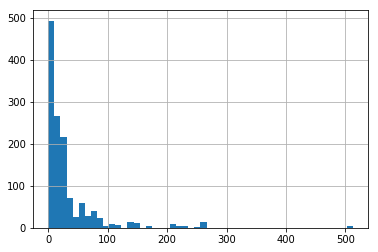

In [13]:
append_set['Fare'].hist(bins=50)

From the above its clear to see there is a massive clustering in the lower fare ranges with a remarkable number at 0.  My best guess as to the reason for this is the staff not having to pay a fare.

From this the obvious bands are - 
1. £0
2. £1 - £50
3. £51 - £100
4. £101 - £200
5. £200+

### Name Length

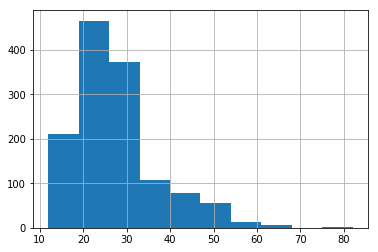

In [12]:
append_set['Name_length'].hist()

So this seems to be somewhat bell shaped with the majority being somewhere between 20 and 30 characters in length.  Splitting along the clear divides in the above chart yields - 

1. <19 chars
2. 19 - 33 chars
3. 33+ chars

In [4]:
#Create function for splitting Fare
def Split_Fare(row) :
    if row['Fare'] == 0 :
        return 1
    elif row['Fare'] <= 50 :
        return 2
    elif row['Fare'] <= 100 :
        return 3
    elif row['Fare'] <= 200 :
        return 4
    else :
        return 5

#Create function to split name
def Split_Name(row) :
    if row['Name_length'] <= 19 :
        return 0
    elif row['Name_length'] <= 33 :
        return 1
    else :
        return 2
    
    
    
#Creating our Training Set
def Cleanse_Data_AutoEnc(df_in):
    #Put our dataframe into new object to avoid corrupting original dataframe
    test_set = df_in
    
    test_set['Fare_Cat'] = test_set.apply(Split_Fare, axis=1)
    test_set['Name_Cat'] = test_set.apply(Split_Name, axis=1)
    
    emb_set = pd.get_dummies(test_set.Embarked, prefix='Emb', dummy_na = False)
    title_set = pd.get_dummies(test_set.Title, prefix='ti', dummy_na = True)
    deck_set = pd.get_dummies(test_set.Deckstr, prefix='de', dummy_na = True)
    fare_set = pd.get_dummies(test_set.Fare_Cat, prefix='Fare', dummy_na = False)
    name_set = pd.get_dummies(test_set.Name_Cat, prefix='Name', dummy_na = False)
    class_set = pd.get_dummies(test_set.Pclass, prefix='Class', dummy_na = False)
    comp_set = pd.get_dummies(test_set.Company, prefix='Comp', dummy_na = False)
    
    oh_set = pd.concat([test_set,  
                        emb_set, 
                        title_set, 
                        deck_set,
                        fare_set,
                        name_set, 
                        class_set], axis=1)
    
    #Create output fully numeric dataframe
    out_set = oh_set.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 
                             'Cabin', 'canc', 'Embarked', 'Title', 'Norm_age', 'Norm_fare', 
                           'Company', 'Pclass', 'Fare_Cat', 'Name_Cat',
                           'Deckstr', 'Age', 'Fare', 'Name_length'], axis=1)
    return out_set

In [5]:
ae_set = Cleanse_Data_AutoEnc(append_set)

In [6]:
ae_set.head(10)

,Sex,Survived,Emb_C,Emb_Q,Emb_S,ti_Master,ti_Miss,ti_Mr,ti_Mrs,ti_Rare,ti_nan,de_0.0,de_1.0,de_2.0,de_3.0,de_4.0,de_5.0,de_6.0,de_7.0,de_8.0,de_nan,Fare_1,Fare_2,Fare_3,Fare_4,Fare_5,Name_0,Name_1,Name_2,Class_1,Class_2,Class_3
0,1,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,0,1.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,0,1.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
4,1,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
5,1,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
6,1,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
7,1,0.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
8,0,1.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
9,0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0


So now we have a fully binary X matrix, meaning we can make a start on a denoising autoencoder to learn a more efficient representation of the above.  

And more importantly we can simply and easily see where our autoencoder makes mistakes and verify the performance.

In [9]:
X_AE_Train, Y_AE_Train, X_AE_CV, Y_AE_CV, X_AE_Test = dataset_splitter(ae_set, cv_size = 150)

So now to build a simple Autoencoder class to dynamically create autoencoders and enable quick training/testing.

In [24]:
class Autoencoder_simple(object):
    def __init__(self, encoder_layers, decoder_layers, num_params, optimizer = 'Adam', loss = 'mean_squared_error'):
        #Initialize variables
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.num_params = num_params
        
        #Define container to take layers
        layer_list = {}
        
        #Get lengths for loops
        encoder_len = len(encoder_layers)
        decoder_len = len(decoder_layers)
        
        #Define input
        input_layer = Input(shape=(num_params,))
        
        #Build Encoder
        for i in range(encoder_len - 1):
            if i == 0 :
                layer_list['Encoder' + str(i)] = Dense(encoder_layers[i], activation = 'relu')(input_layer)
            else :
                layer_list['Encoder' + str(i)] = Dense(encoder_layers[i], activation = 'relu')(layer_list['Encoder' + str(i - 1)])
        
        layer_list['Encoded_layer'] = Dense(encoder_layers[encoder_len - 1], activation = 'sigmoid')(layer_list['Encoder' + str(encoder_len - 2)])
        
        #Build Decoder
        for j in range(decoder_len):
            if j == 0 :
                layer_list['Decoder' + str(j)] = Dense(decoder_layers[j], activation = 'relu')(layer_list['Encoded_layer'])
            else :
                layer_list['Decoder' + str(j)] = Dense(decoder_layers[j], activation = 'relu')(layer_list['Decoder' + str(j - 1)])
        
        layer_list['Decoded_layer'] = Dense(num_params, activation = 'sigmoid')(layer_list['Decoder' + str(decoder_len - 1)])
        
        
        
        
        #Build Keras models to train/use
        self.encoder = Model(input_layer,layer_list['Encoded_layer'])
        self.autoencoder = Model(input_layer, layer_list['Decoded_layer'])
        
        self.autoencoder.compile(optimizer = optimizer, loss = loss)
    
    def Train_autoencoder(self, X_Train, X_CV, epoch = 500, bat_size = 64):
        self.autoencoder.fit(X_Train, X_Train,
                epochs=epoch,
                batch_size=bat_size,
                shuffle=True,
                validation_data=(X_CV, X_CV))
    
    def Train_Denoise_autoencoder(self,X_in, X_true, X_CV, epoch = 500, bat_size = 64):
        self.autoencoder.fit(X_in, X_true,
                epochs=epoch,
                batch_size=bat_size,
                shuffle=True,
                validation_data=(X_CV, X_CV))
    
    
    def Test_Accuracy(self, X_Acc) :
        Y_Acc = self.autoencoder.predict(X_Acc)
        
        
        ae_out = normalize_predictions(Y_Acc.flatten())
        ae_in = X_Acc.flatten()
        
        show_acc(ae_in, ae_out)
    
    def Get_Encoding(self, X_in) :
        encode_out = self.encoder.predict(X_in)
        
        return encode_out
        

In [25]:
enc_lay = [25, 20, 15, 10]
dec_lay = [15, 20, 25]
num_params = X_AE_Train.shape[1]


test_ae = Autoencoder_simple(enc_lay, dec_lay, num_params)

In [26]:
test_ae.Train_autoencoder(X_AE_Train, X_AE_CV)

Train on 741 samples, validate on 150 samples
Epoch 1/500
741/741 [==============================] - 0s 579us/step - loss: 0.2446 - val_loss: 0.2355
Epoch 2/500
741/741 [==============================] - 0s 131us/step - loss: 0.2294 - val_loss: 0.2204
Epoch 3/500
741/741 [==============================] - 0s 130us/step - loss: 0.2116 - val_loss: 0.1984
Epoch 4/500
741/741 [==============================] - 0s 131us/step - loss: 0.1857 - val_loss: 0.1687
Epoch 5/500
741/741 [==============================] - 0s 135us/step - loss: 0.1534 - val_loss: 0.1368
Epoch 6/500
741/741 [==============================] - 0s 134us/step - loss: 0.1236 - val_loss: 0.1143
Epoch 7/500
741/741 [==============================] - 0s 134us/step - loss: 0.1072 - val_loss: 0.1072
Epoch 8/500
741/741 [==============================] - 0s 135us/step - loss: 0.1026 - val_loss: 0.1059
Epoch 9/500
741/741 [==============================] - 0s 140us/step - loss: 0.1012 - val_loss: 0.1050
Epoch 10/500
741/741 [=====

741/741 [==============================] - 0s 131us/step - loss: 0.0306 - val_loss: 0.0334
Epoch 80/500
741/741 [==============================] - 0s 128us/step - loss: 0.0302 - val_loss: 0.0331
Epoch 81/500
741/741 [==============================] - 0s 127us/step - loss: 0.0299 - val_loss: 0.0326
Epoch 82/500
741/741 [==============================] - 0s 134us/step - loss: 0.0294 - val_loss: 0.0323
Epoch 83/500
741/741 [==============================] - 0s 131us/step - loss: 0.0288 - val_loss: 0.0317
Epoch 84/500
741/741 [==============================] - 0s 130us/step - loss: 0.0283 - val_loss: 0.0314
Epoch 85/500
741/741 [==============================] - 0s 130us/step - loss: 0.0280 - val_loss: 0.0311
Epoch 86/500
741/741 [==============================] - 0s 140us/step - loss: 0.0275 - val_loss: 0.0309
Epoch 87/500
741/741 [==============================] - 0s 128us/step - loss: 0.0271 - val_loss: 0.0305
Epoch 88/500
741/741 [==============================] - 0s 130us/step - loss:

741/741 [==============================] - 0s 131us/step - loss: 0.0178 - val_loss: 0.0217
Epoch 158/500
741/741 [==============================] - 0s 138us/step - loss: 0.0178 - val_loss: 0.0217
Epoch 159/500
741/741 [==============================] - 0s 131us/step - loss: 0.0177 - val_loss: 0.0218
Epoch 160/500
741/741 [==============================] - 0s 134us/step - loss: 0.0177 - val_loss: 0.0216
Epoch 161/500
741/741 [==============================] - 0s 132us/step - loss: 0.0176 - val_loss: 0.0215
Epoch 162/500
741/741 [==============================] - 0s 131us/step - loss: 0.0175 - val_loss: 0.0216
Epoch 163/500
741/741 [==============================] - 0s 131us/step - loss: 0.0174 - val_loss: 0.0213
Epoch 164/500
741/741 [==============================] - 0s 135us/step - loss: 0.0174 - val_loss: 0.0213
Epoch 165/500
741/741 [==============================] - 0s 127us/step - loss: 0.0173 - val_loss: 0.0215
Epoch 166/500
741/741 [==============================] - 0s 136us/ste

741/741 [==============================] - 0s 127us/step - loss: 0.0137 - val_loss: 0.0189
Epoch 236/500
741/741 [==============================] - 0s 130us/step - loss: 0.0137 - val_loss: 0.0185
Epoch 237/500
741/741 [==============================] - 0s 128us/step - loss: 0.0136 - val_loss: 0.0186
Epoch 238/500
741/741 [==============================] - 0s 130us/step - loss: 0.0135 - val_loss: 0.0191
Epoch 239/500
741/741 [==============================] - 0s 131us/step - loss: 0.0136 - val_loss: 0.0188
Epoch 240/500
741/741 [==============================] - 0s 130us/step - loss: 0.0136 - val_loss: 0.0186
Epoch 241/500
741/741 [==============================] - 0s 132us/step - loss: 0.0135 - val_loss: 0.0187
Epoch 242/500
741/741 [==============================] - 0s 132us/step - loss: 0.0135 - val_loss: 0.0187
Epoch 243/500
741/741 [==============================] - 0s 131us/step - loss: 0.0135 - val_loss: 0.0187
Epoch 244/500
741/741 [==============================] - 0s 134us/ste

741/741 [==============================] - 0s 134us/step - loss: 0.0125 - val_loss: 0.0188
Epoch 314/500
741/741 [==============================] - 0s 128us/step - loss: 0.0124 - val_loss: 0.0185
Epoch 315/500
741/741 [==============================] - 0s 131us/step - loss: 0.0124 - val_loss: 0.0186
Epoch 316/500
741/741 [==============================] - 0s 128us/step - loss: 0.0124 - val_loss: 0.0186
Epoch 317/500
741/741 [==============================] - 0s 130us/step - loss: 0.0124 - val_loss: 0.0186
Epoch 318/500
741/741 [==============================] - 0s 130us/step - loss: 0.0123 - val_loss: 0.0189
Epoch 319/500
741/741 [==============================] - 0s 131us/step - loss: 0.0123 - val_loss: 0.0185
Epoch 320/500
741/741 [==============================] - 0s 127us/step - loss: 0.0124 - val_loss: 0.0186
Epoch 321/500
741/741 [==============================] - 0s 132us/step - loss: 0.0124 - val_loss: 0.0185
Epoch 322/500
741/741 [==============================] - 0s 130us/ste

741/741 [==============================] - 0s 130us/step - loss: 0.0118 - val_loss: 0.0188
Epoch 392/500
741/741 [==============================] - 0s 130us/step - loss: 0.0118 - val_loss: 0.0188
Epoch 393/500
741/741 [==============================] - 0s 132us/step - loss: 0.0118 - val_loss: 0.0190
Epoch 394/500
741/741 [==============================] - 0s 131us/step - loss: 0.0118 - val_loss: 0.0189
Epoch 395/500
741/741 [==============================] - 0s 134us/step - loss: 0.0117 - val_loss: 0.0188
Epoch 396/500
741/741 [==============================] - 0s 138us/step - loss: 0.0117 - val_loss: 0.0187
Epoch 397/500
741/741 [==============================] - 0s 130us/step - loss: 0.0117 - val_loss: 0.0189
Epoch 398/500
741/741 [==============================] - 0s 132us/step - loss: 0.0117 - val_loss: 0.0187
Epoch 399/500
741/741 [==============================] - 0s 136us/step - loss: 0.0117 - val_loss: 0.0189
Epoch 400/500
741/741 [==============================] - 0s 140us/ste

741/741 [==============================] - 0s 132us/step - loss: 0.0115 - val_loss: 0.0193
Epoch 470/500
741/741 [==============================] - 0s 138us/step - loss: 0.0114 - val_loss: 0.0184
Epoch 471/500
741/741 [==============================] - 0s 131us/step - loss: 0.0113 - val_loss: 0.0195
Epoch 472/500
741/741 [==============================] - 0s 130us/step - loss: 0.0115 - val_loss: 0.0185
Epoch 473/500
741/741 [==============================] - 0s 128us/step - loss: 0.0114 - val_loss: 0.0188
Epoch 474/500
741/741 [==============================] - 0s 131us/step - loss: 0.0114 - val_loss: 0.0188
Epoch 475/500
741/741 [==============================] - 0s 132us/step - loss: 0.0112 - val_loss: 0.0185
Epoch 476/500
741/741 [==============================] - 0s 130us/step - loss: 0.0112 - val_loss: 0.0189
Epoch 477/500
741/741 [==============================] - 0s 130us/step - loss: 0.0114 - val_loss: 0.0189
Epoch 478/500
741/741 [==============================] - 0s 130us/ste

In [27]:
test_ae.Test_Accuracy(X_AE_Train)

Accuracy =  98.88990466240043
F1 Score =  0.9738488360168187

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True       4748.0          76.0
1  Pred False        179.0       17968.0


In [28]:
test_ae.Test_Accuracy(X_AE_CV)

Accuracy =  98.02150537634408
F1 Score =  0.9530132788559754

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        933.0          31.0
1  Pred False         61.0        3625.0


In [29]:
test_ae.Test_Accuracy(X_AE_Test)

Accuracy =  98.37166229356382
F1 Score =  0.961404792390708

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True       2628.0          65.0
1  Pred False        146.0       10119.0


So from the above it seems we have a solid foundation from which to start.  

The next step is to add a further step of robustness to the process and adding corruption to the input.  This should add a degree of robustness to outliers.

The process for this is simple - 
1. Generate uniform random numbers in matrix of shape ($X_0, X_1$)
2. Set elements of matrix as 1 if below a probability threshold, else set to 0.
3. Mask original X by means of the absolute value of mask - X (as such any element with mask 1 is flipped, otherwise left as it is).

In [30]:
#Credit to Path of Exile for naming convention
def Corrupt_data(Orig_X, Probability = 0.001) :
    Rand_set = np.random.uniform(size=Orig_X.shape)
    
    Vaal_Mask = 1 - np.heaviside(Rand_set - Probability, 1)
    
    Vaal_X = np.absolute(Vaal_Mask - Orig_X)
    
    return Vaal_X

Now to train a denoising autoencoder the process is simple - corrupt the input with the above function, and feed this corrupted input in against the ground truth as comparison and see how it does, comparing against the above.

In [31]:
Vaal_X_AE_Train = Corrupt_data(X_AE_Train, 0.1)

In [32]:
denoise_ae = Autoencoder_simple(enc_lay, dec_lay, num_params)
denoise_ae.Train_Denoise_autoencoder(Vaal_X_AE_Train, X_AE_Train, X_AE_CV)

Train on 741 samples, validate on 150 samples
Epoch 1/500
741/741 [==============================] - 0s 618us/step - loss: 0.2456 - val_loss: 0.2391
Epoch 2/500
741/741 [==============================] - 0s 131us/step - loss: 0.2327 - val_loss: 0.2246
Epoch 3/500
741/741 [==============================] - 0s 132us/step - loss: 0.2151 - val_loss: 0.2041
Epoch 4/500
741/741 [==============================] - 0s 135us/step - loss: 0.1911 - val_loss: 0.1780
Epoch 5/500
741/741 [==============================] - 0s 131us/step - loss: 0.1643 - val_loss: 0.1530
Epoch 6/500
741/741 [==============================] - 0s 138us/step - loss: 0.1419 - val_loss: 0.1362
Epoch 7/500
741/741 [==============================] - 0s 136us/step - loss: 0.1283 - val_loss: 0.1264
Epoch 8/500
741/741 [==============================] - 0s 131us/step - loss: 0.1199 - val_loss: 0.1198
Epoch 9/500
741/741 [==============================] - 0s 138us/step - loss: 0.1139 - val_loss: 0.1145
Epoch 10/500
741/741 [=====

741/741 [==============================] - 0s 135us/step - loss: 0.0480 - val_loss: 0.0455
Epoch 80/500
741/741 [==============================] - 0s 135us/step - loss: 0.0477 - val_loss: 0.0457
Epoch 81/500
741/741 [==============================] - 0s 162us/step - loss: 0.0476 - val_loss: 0.0455
Epoch 82/500
741/741 [==============================] - 0s 148us/step - loss: 0.0474 - val_loss: 0.0454
Epoch 83/500
741/741 [==============================] - 0s 135us/step - loss: 0.0472 - val_loss: 0.0451
Epoch 84/500
741/741 [==============================] - 0s 135us/step - loss: 0.0470 - val_loss: 0.0448
Epoch 85/500
741/741 [==============================] - 0s 135us/step - loss: 0.0469 - val_loss: 0.0450
Epoch 86/500
741/741 [==============================] - 0s 121us/step - loss: 0.0466 - val_loss: 0.0445
Epoch 87/500
741/741 [==============================] - 0s 121us/step - loss: 0.0464 - val_loss: 0.0444
Epoch 88/500
741/741 [==============================] - 0s 135us/step - loss:

741/741 [==============================] - 0s 148us/step - loss: 0.0363 - val_loss: 0.0366
Epoch 158/500
741/741 [==============================] - 0s 135us/step - loss: 0.0361 - val_loss: 0.0365
Epoch 159/500
741/741 [==============================] - 0s 135us/step - loss: 0.0359 - val_loss: 0.0367
Epoch 160/500
741/741 [==============================] - 0s 135us/step - loss: 0.0360 - val_loss: 0.0366
Epoch 161/500
741/741 [==============================] - 0s 121us/step - loss: 0.0357 - val_loss: 0.0361
Epoch 162/500
741/741 [==============================] - 0s 135us/step - loss: 0.0356 - val_loss: 0.0360
Epoch 163/500
741/741 [==============================] - 0s 135us/step - loss: 0.0355 - val_loss: 0.0360
Epoch 164/500
741/741 [==============================] - 0s 135us/step - loss: 0.0353 - val_loss: 0.0359
Epoch 165/500
741/741 [==============================] - 0s 135us/step - loss: 0.0353 - val_loss: 0.0358
Epoch 166/500
741/741 [==============================] - 0s 148us/ste

741/741 [==============================] - 0s 135us/step - loss: 0.0301 - val_loss: 0.0339
Epoch 236/500
741/741 [==============================] - 0s 135us/step - loss: 0.0304 - val_loss: 0.0333
Epoch 237/500
741/741 [==============================] - 0s 121us/step - loss: 0.0301 - val_loss: 0.0336
Epoch 238/500
741/741 [==============================] - 0s 148us/step - loss: 0.0300 - val_loss: 0.0336
Epoch 239/500
741/741 [==============================] - 0s 135us/step - loss: 0.0299 - val_loss: 0.0332
Epoch 240/500
741/741 [==============================] - 0s 135us/step - loss: 0.0299 - val_loss: 0.0340
Epoch 241/500
741/741 [==============================] - 0s 148us/step - loss: 0.0299 - val_loss: 0.0336
Epoch 242/500
741/741 [==============================] - 0s 148us/step - loss: 0.0296 - val_loss: 0.0336
Epoch 243/500
741/741 [==============================] - 0s 148us/step - loss: 0.0297 - val_loss: 0.0336
Epoch 244/500
741/741 [==============================] - 0s 135us/ste

741/741 [==============================] - 0s 135us/step - loss: 0.0269 - val_loss: 0.0325
Epoch 314/500
741/741 [==============================] - 0s 148us/step - loss: 0.0268 - val_loss: 0.0324
Epoch 315/500
741/741 [==============================] - 0s 121us/step - loss: 0.0267 - val_loss: 0.0324
Epoch 316/500
741/741 [==============================] - 0s 121us/step - loss: 0.0265 - val_loss: 0.0322
Epoch 317/500
741/741 [==============================] - 0s 135us/step - loss: 0.0265 - val_loss: 0.0322
Epoch 318/500
741/741 [==============================] - 0s 135us/step - loss: 0.0264 - val_loss: 0.0323
Epoch 319/500
741/741 [==============================] - 0s 135us/step - loss: 0.0265 - val_loss: 0.0323
Epoch 320/500
741/741 [==============================] - 0s 135us/step - loss: 0.0265 - val_loss: 0.0322
Epoch 321/500
741/741 [==============================] - 0s 135us/step - loss: 0.0263 - val_loss: 0.0320
Epoch 322/500
741/741 [==============================] - 0s 135us/ste

741/741 [==============================] - 0s 135us/step - loss: 0.0239 - val_loss: 0.0312
Epoch 392/500
741/741 [==============================] - 0s 135us/step - loss: 0.0239 - val_loss: 0.0311
Epoch 393/500
741/741 [==============================] - 0s 121us/step - loss: 0.0239 - val_loss: 0.0313
Epoch 394/500
741/741 [==============================] - 0s 162us/step - loss: 0.0238 - val_loss: 0.0311
Epoch 395/500
741/741 [==============================] - 0s 135us/step - loss: 0.0239 - val_loss: 0.0311
Epoch 396/500
741/741 [==============================] - 0s 121us/step - loss: 0.0237 - val_loss: 0.0316
Epoch 397/500
741/741 [==============================] - 0s 135us/step - loss: 0.0236 - val_loss: 0.0313
Epoch 398/500
741/741 [==============================] - 0s 148us/step - loss: 0.0236 - val_loss: 0.0314
Epoch 399/500
741/741 [==============================] - 0s 135us/step - loss: 0.0236 - val_loss: 0.0314
Epoch 400/500
741/741 [==============================] - 0s 148us/ste

741/741 [==============================] - 0s 135us/step - loss: 0.0221 - val_loss: 0.0314
Epoch 470/500
741/741 [==============================] - 0s 121us/step - loss: 0.0221 - val_loss: 0.0312
Epoch 471/500
741/741 [==============================] - 0s 135us/step - loss: 0.0221 - val_loss: 0.0310
Epoch 472/500
741/741 [==============================] - 0s 135us/step - loss: 0.0220 - val_loss: 0.0315
Epoch 473/500
741/741 [==============================] - 0s 148us/step - loss: 0.0218 - val_loss: 0.0313
Epoch 474/500
741/741 [==============================] - 0s 148us/step - loss: 0.0220 - val_loss: 0.0314
Epoch 475/500
741/741 [==============================] - 0s 148us/step - loss: 0.0218 - val_loss: 0.0315
Epoch 476/500
741/741 [==============================] - 0s 135us/step - loss: 0.0217 - val_loss: 0.0316
Epoch 477/500
741/741 [==============================] - 0s 135us/step - loss: 0.0216 - val_loss: 0.0312
Epoch 478/500
741/741 [==============================] - 0s 135us/ste

In [33]:
denoise_ae.Test_Accuracy(X_AE_Train)

Accuracy =  96.95703278046233
F1 Score =  0.9281677114376735

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True       4516.0         288.0
1  Pred False        411.0       17756.0


In [34]:
denoise_ae.Test_Accuracy(X_AE_CV)

Accuracy =  96.19354838709677
F1 Score =  0.9098318899643402

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        893.0          76.0
1  Pred False        101.0        3580.0


In [35]:
denoise_ae.Test_Accuracy(X_AE_Test)

Accuracy =  96.67386942429387
F1 Score =  0.921307285010042

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True       2523.0         180.0
1  Pred False        251.0       10004.0


So this works pretty well and seems to learn a reasonably robust representation of the data. 

Experimenting with different probabilities of corruption on the input has been surprising as even a 50% corrupted input still yields a greater than 50% accuracy, although this could be the network learning the patterns in the random number generation more than a representation of the data.

Eventually it seems like a corruption of 10% still yields a solid representation with similar accuracy scores to 0 corruption so I will use this as a placeholder value for testing how well the encoded representation can be used by a classifier.

To compare I will use a simple 3 way test - comparing the accuracy of a neural network with the same architecture with the earlier layers being the denoising autoencoder, the simple autoencoder and no pretraining respectively on the same binary encoded input.

In [36]:
#Get simple autoencoder inputs
S_AE_Train = test_ae.Get_Encoding(X_AE_Train)
S_AE_CV = test_ae.Get_Encoding(X_AE_CV)

#Get denoising autoencoder inputs
D_AE_Train = denoise_ae.Get_Encoding(X_AE_Train)
D_AE_CV = denoise_ae.Get_Encoding(X_AE_CV)

#Generate autoencoder networks
AE_layers = [10, 7, 5, 5, 3, 3]

In [58]:
#Build Simple Model network
simple_model = NN_model((S_AE_Train.shape[1], ), AE_layers, regularizers.l2(0.001), None)
simple_model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])
simple_model.fit(x = S_AE_Train, y = Y_AE_Train, epochs = 500, verbose = 1)


s_train_pred = simple_model.predict(x = S_AE_Train)
s_cv_pred = simple_model.predict(x = S_AE_CV)

s_train_hat = normalize_predictions(s_train_pred)
s_cv_hat = normalize_predictions(s_cv_pred)

Epoch 1/500
741/741 [==============================] - 1s 2ms/step - loss: 0.7804 - acc: 0.3522
Epoch 2/500
741/741 [==============================] - 0s 298us/step - loss: 0.7285 - acc: 0.5614
Epoch 3/500
741/741 [==============================] - 0s 292us/step - loss: 0.7058 - acc: 0.6977
Epoch 4/500
741/741 [==============================] - 0s 293us/step - loss: 0.6941 - acc: 0.7031
Epoch 5/500
741/741 [==============================] - 0s 294us/step - loss: 0.6849 - acc: 0.7328
Epoch 6/500
741/741 [==============================] - 0s 301us/step - loss: 0.6774 - acc: 0.7584
Epoch 7/500
741/741 [==============================] - 0s 298us/step - loss: 0.6698 - acc: 0.7625
Epoch 8/500
741/741 [==============================] - 0s 296us/step - loss: 0.6632 - acc: 0.7625
Epoch 9/500
741/741 [==============================] - 0s 306us/step - loss: 0.6559 - acc: 0.7679
Epoch 10/500
741/741 [==============================] - 0s 296us/step - loss: 0.6492 - acc: 0.7706
Epoch 11/500
741/741 

741/741 [==============================] - 0s 297us/step - loss: 0.4631 - acc: 0.8381
Epoch 84/500
741/741 [==============================] - 0s 282us/step - loss: 0.4587 - acc: 0.8367
Epoch 85/500
741/741 [==============================] - 0s 283us/step - loss: 0.4629 - acc: 0.8313
Epoch 86/500
741/741 [==============================] - 0s 292us/step - loss: 0.4626 - acc: 0.8286
Epoch 87/500
741/741 [==============================] - 0s 285us/step - loss: 0.4571 - acc: 0.8340
Epoch 88/500
741/741 [==============================] - 0s 293us/step - loss: 0.4572 - acc: 0.8394
Epoch 89/500
741/741 [==============================] - 0s 287us/step - loss: 0.4567 - acc: 0.8340
Epoch 90/500
741/741 [==============================] - 0s 285us/step - loss: 0.4567 - acc: 0.8313
Epoch 91/500
741/741 [==============================] - 0s 290us/step - loss: 0.4568 - acc: 0.8367
Epoch 92/500
741/741 [==============================] - 0s 292us/step - loss: 0.4567 - acc: 0.8300
Epoch 93/500
741/741 [=

741/741 [==============================] - 0s 290us/step - loss: 0.4306 - acc: 0.8421
Epoch 166/500
741/741 [==============================] - 0s 287us/step - loss: 0.4297 - acc: 0.8448
Epoch 167/500
741/741 [==============================] - 0s 293us/step - loss: 0.4288 - acc: 0.8448
Epoch 168/500
741/741 [==============================] - 0s 296us/step - loss: 0.4307 - acc: 0.8327
Epoch 169/500
741/741 [==============================] - 0s 289us/step - loss: 0.4317 - acc: 0.8340
Epoch 170/500
741/741 [==============================] - 0s 285us/step - loss: 0.4275 - acc: 0.8448
Epoch 171/500
741/741 [==============================] - 0s 285us/step - loss: 0.4344 - acc: 0.8421
Epoch 172/500
741/741 [==============================] - 0s 287us/step - loss: 0.4336 - acc: 0.8300
Epoch 173/500
741/741 [==============================] - 0s 289us/step - loss: 0.4332 - acc: 0.8408
Epoch 174/500
741/741 [==============================] - 0s 292us/step - loss: 0.4311 - acc: 0.8421
Epoch 175/500


741/741 [==============================] - 0s 292us/step - loss: 0.4172 - acc: 0.8408
Epoch 247/500
741/741 [==============================] - 0s 286us/step - loss: 0.4183 - acc: 0.8367
Epoch 248/500
741/741 [==============================] - 0s 300us/step - loss: 0.4147 - acc: 0.8489
Epoch 249/500
741/741 [==============================] - 0s 312us/step - loss: 0.4143 - acc: 0.8435
Epoch 250/500
741/741 [==============================] - 0s 321us/step - loss: 0.4144 - acc: 0.8435
Epoch 251/500
741/741 [==============================] - 0s 306us/step - loss: 0.4134 - acc: 0.8462
Epoch 252/500
741/741 [==============================] - 0s 287us/step - loss: 0.4158 - acc: 0.8367
Epoch 253/500
741/741 [==============================] - 0s 287us/step - loss: 0.4145 - acc: 0.8462
Epoch 254/500
741/741 [==============================] - 0s 290us/step - loss: 0.4130 - acc: 0.8421
Epoch 255/500
741/741 [==============================] - 0s 286us/step - loss: 0.4222 - acc: 0.8475
Epoch 256/500


741/741 [==============================] - 0s 309us/step - loss: 0.4077 - acc: 0.8435
Epoch 328/500
741/741 [==============================] - 0s 308us/step - loss: 0.4086 - acc: 0.8381
Epoch 329/500
741/741 [==============================] - 0s 293us/step - loss: 0.4063 - acc: 0.8475
Epoch 330/500
741/741 [==============================] - 0s 293us/step - loss: 0.4059 - acc: 0.8475
Epoch 331/500
741/741 [==============================] - 0s 287us/step - loss: 0.4105 - acc: 0.8381
Epoch 332/500
741/741 [==============================] - 0s 290us/step - loss: 0.4112 - acc: 0.8435
Epoch 333/500
741/741 [==============================] - 0s 292us/step - loss: 0.4096 - acc: 0.8448
Epoch 334/500
741/741 [==============================] - 0s 296us/step - loss: 0.4089 - acc: 0.8435
Epoch 335/500
741/741 [==============================] - 0s 294us/step - loss: 0.4066 - acc: 0.8408
Epoch 336/500
741/741 [==============================] - 0s 294us/step - loss: 0.4062 - acc: 0.8489
Epoch 337/500


741/741 [==============================] - 0s 316us/step - loss: 0.4057 - acc: 0.8435
Epoch 410/500
741/741 [==============================] - 0s 320us/step - loss: 0.4029 - acc: 0.8502
Epoch 411/500
741/741 [==============================] - 0s 306us/step - loss: 0.4025 - acc: 0.8448
Epoch 412/500
741/741 [==============================] - 0s 321us/step - loss: 0.4032 - acc: 0.8462
Epoch 413/500
741/741 [==============================] - 0s 308us/step - loss: 0.4086 - acc: 0.8462
Epoch 414/500
741/741 [==============================] - 0s 312us/step - loss: 0.4045 - acc: 0.8462
Epoch 415/500
741/741 [==============================] - 0s 325us/step - loss: 0.4037 - acc: 0.8462
Epoch 416/500
741/741 [==============================] - 0s 308us/step - loss: 0.4013 - acc: 0.8489
Epoch 417/500
741/741 [==============================] - 0s 308us/step - loss: 0.4061 - acc: 0.8394
Epoch 418/500
741/741 [==============================] - 0s 316us/step - loss: 0.4052 - acc: 0.8421
Epoch 419/500


741/741 [==============================] - 0s 321us/step - loss: 0.4052 - acc: 0.8475
Epoch 492/500
741/741 [==============================] - 0s 323us/step - loss: 0.4100 - acc: 0.8381
Epoch 493/500
741/741 [==============================] - 0s 310us/step - loss: 0.4069 - acc: 0.8462
Epoch 494/500
741/741 [==============================] - 0s 309us/step - loss: 0.4103 - acc: 0.8448
Epoch 495/500
741/741 [==============================] - 0s 304us/step - loss: 0.4119 - acc: 0.8408
Epoch 496/500
741/741 [==============================] - 0s 312us/step - loss: 0.4074 - acc: 0.8408
Epoch 497/500
741/741 [==============================] - 0s 317us/step - loss: 0.4060 - acc: 0.8421
Epoch 498/500
741/741 [==============================] - 0s 312us/step - loss: 0.4081 - acc: 0.8448
Epoch 499/500
741/741 [==============================] - 0s 306us/step - loss: 0.4064 - acc: 0.8435
Epoch 500/500
741/741 [==============================] - 0s 310us/step - loss: 0.4081 - acc: 0.8448


In [61]:
#Build Denoising Model network
denoise_model = NN_model((D_AE_Train.shape[1], ), AE_layers, regularizers.l2(0.001), None)
denoise_model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])
denoise_model.fit(x = D_AE_Train, y = Y_AE_Train, epochs = 500, verbose = 1)


d_train_pred = denoise_model.predict(x = D_AE_Train)
d_cv_pred = denoise_model.predict(x = D_AE_CV)

d_train_hat = normalize_predictions(d_train_pred)
d_cv_hat = normalize_predictions(d_cv_pred)

Epoch 1/500
741/741 [==============================] - 1s 2ms/step - loss: 0.7137 - acc: 0.6181
Epoch 2/500
741/741 [==============================] - 0s 293us/step - loss: 0.6943 - acc: 0.6181
Epoch 3/500
741/741 [==============================] - 0s 293us/step - loss: 0.6834 - acc: 0.6181
Epoch 4/500
741/741 [==============================] - 0s 293us/step - loss: 0.6743 - acc: 0.6181
Epoch 5/500
741/741 [==============================] - 0s 292us/step - loss: 0.6632 - acc: 0.6181
Epoch 6/500
741/741 [==============================] - 0s 296us/step - loss: 0.6516 - acc: 0.6181
Epoch 7/500
741/741 [==============================] - 0s 290us/step - loss: 0.6398 - acc: 0.6181
Epoch 8/500
741/741 [==============================] - 0s 289us/step - loss: 0.6271 - acc: 0.6181
Epoch 9/500
741/741 [==============================] - 0s 293us/step - loss: 0.6173 - acc: 0.6181
Epoch 10/500
741/741 [==============================] - 0s 289us/step - loss: 0.6091 - acc: 0.6181
Epoch 11/500
741/741 

741/741 [==============================] - 0s 336us/step - loss: 0.4796 - acc: 0.8273
Epoch 84/500
741/741 [==============================] - 0s 328us/step - loss: 0.4782 - acc: 0.8340
Epoch 85/500
741/741 [==============================] - 0s 320us/step - loss: 0.4771 - acc: 0.8367
Epoch 86/500
741/741 [==============================] - 0s 314us/step - loss: 0.4777 - acc: 0.8354
Epoch 87/500
741/741 [==============================] - 0s 336us/step - loss: 0.4748 - acc: 0.8367
Epoch 88/500
741/741 [==============================] - 0s 323us/step - loss: 0.4725 - acc: 0.8394
Epoch 89/500
741/741 [==============================] - 0s 313us/step - loss: 0.4710 - acc: 0.8408
Epoch 90/500
741/741 [==============================] - 0s 306us/step - loss: 0.4730 - acc: 0.8367
Epoch 91/500
741/741 [==============================] - 0s 320us/step - loss: 0.4724 - acc: 0.8367
Epoch 92/500
741/741 [==============================] - 0s 325us/step - loss: 0.4755 - acc: 0.8354
Epoch 93/500
741/741 [=

741/741 [==============================] - 0s 308us/step - loss: 0.4374 - acc: 0.8462
Epoch 165/500
741/741 [==============================] - 0s 320us/step - loss: 0.4325 - acc: 0.8489
Epoch 166/500
741/741 [==============================] - 0s 314us/step - loss: 0.4348 - acc: 0.8462
Epoch 167/500
741/741 [==============================] - 0s 309us/step - loss: 0.4351 - acc: 0.8462
Epoch 168/500
741/741 [==============================] - 0s 323us/step - loss: 0.4317 - acc: 0.8475
Epoch 169/500
741/741 [==============================] - 0s 316us/step - loss: 0.4340 - acc: 0.8489
Epoch 170/500
741/741 [==============================] - 0s 331us/step - loss: 0.4336 - acc: 0.8435
Epoch 171/500
741/741 [==============================] - 0s 323us/step - loss: 0.4326 - acc: 0.8489
Epoch 172/500
741/741 [==============================] - 0s 320us/step - loss: 0.4335 - acc: 0.8529
Epoch 173/500
741/741 [==============================] - 0s 310us/step - loss: 0.4304 - acc: 0.8475
Epoch 174/500


741/741 [==============================] - 0s 312us/step - loss: 0.4196 - acc: 0.8489
Epoch 246/500
741/741 [==============================] - 0s 308us/step - loss: 0.4113 - acc: 0.8516
Epoch 247/500
741/741 [==============================] - 0s 310us/step - loss: 0.4103 - acc: 0.8529
Epoch 248/500
741/741 [==============================] - 0s 314us/step - loss: 0.4141 - acc: 0.8475
Epoch 249/500
741/741 [==============================] - 0s 312us/step - loss: 0.4157 - acc: 0.8516
Epoch 250/500
741/741 [==============================] - 0s 323us/step - loss: 0.4122 - acc: 0.8489 0s - loss: 0.4001 - acc: 0.85
Epoch 251/500
741/741 [==============================] - 0s 321us/step - loss: 0.4150 - acc: 0.8543
Epoch 252/500
741/741 [==============================] - 0s 325us/step - loss: 0.4129 - acc: 0.8489
Epoch 253/500
741/741 [==============================] - 0s 309us/step - loss: 0.4189 - acc: 0.8502
Epoch 254/500
741/741 [==============================] - 0s 333us/step - loss: 0.413

741/741 [==============================] - 0s 337us/step - loss: 0.4023 - acc: 0.8502
Epoch 327/500
741/741 [==============================] - 0s 355us/step - loss: 0.3988 - acc: 0.8516
Epoch 328/500
741/741 [==============================] - 0s 356us/step - loss: 0.3993 - acc: 0.8516
Epoch 329/500
741/741 [==============================] - 0s 331us/step - loss: 0.4176 - acc: 0.8340
Epoch 330/500
741/741 [==============================] - 0s 320us/step - loss: 0.4033 - acc: 0.8516
Epoch 331/500
741/741 [==============================] - 0s 316us/step - loss: 0.4106 - acc: 0.8408
Epoch 332/500
741/741 [==============================] - 0s 329us/step - loss: 0.4027 - acc: 0.8583
Epoch 333/500
741/741 [==============================] - 0s 321us/step - loss: 0.4003 - acc: 0.8556
Epoch 334/500
741/741 [==============================] - 0s 329us/step - loss: 0.3989 - acc: 0.8475
Epoch 335/500
741/741 [==============================] - 0s 319us/step - loss: 0.4015 - acc: 0.8435
Epoch 336/500


741/741 [==============================] - 0s 316us/step - loss: 0.3905 - acc: 0.8583
Epoch 408/500
741/741 [==============================] - 0s 314us/step - loss: 0.3912 - acc: 0.8516
Epoch 409/500
741/741 [==============================] - 0s 328us/step - loss: 0.3871 - acc: 0.8502
Epoch 410/500
741/741 [==============================] - 0s 309us/step - loss: 0.3961 - acc: 0.8462
Epoch 411/500
741/741 [==============================] - 0s 333us/step - loss: 0.3924 - acc: 0.8489
Epoch 412/500
741/741 [==============================] - 0s 312us/step - loss: 0.3956 - acc: 0.8448
Epoch 413/500
741/741 [==============================] - 0s 319us/step - loss: 0.4003 - acc: 0.8448
Epoch 414/500
741/741 [==============================] - 0s 312us/step - loss: 0.3885 - acc: 0.8583
Epoch 415/500
741/741 [==============================] - 0s 317us/step - loss: 0.3905 - acc: 0.8556
Epoch 416/500
741/741 [==============================] - 0s 317us/step - loss: 0.3932 - acc: 0.8556
Epoch 417/500


741/741 [==============================] - 0s 313us/step - loss: 0.3940 - acc: 0.8475
Epoch 490/500
741/741 [==============================] - 0s 310us/step - loss: 0.3875 - acc: 0.8529
Epoch 491/500
741/741 [==============================] - 0s 321us/step - loss: 0.3876 - acc: 0.8583
Epoch 492/500
741/741 [==============================] - 0s 313us/step - loss: 0.3890 - acc: 0.8556
Epoch 493/500
741/741 [==============================] - 0s 314us/step - loss: 0.3888 - acc: 0.8570
Epoch 494/500
741/741 [==============================] - 0s 323us/step - loss: 0.3864 - acc: 0.8570
Epoch 495/500
741/741 [==============================] - 0s 313us/step - loss: 0.3951 - acc: 0.8489
Epoch 496/500
741/741 [==============================] - 0s 314us/step - loss: 0.4013 - acc: 0.8462
Epoch 497/500
741/741 [==============================] - 0s 314us/step - loss: 0.3918 - acc: 0.8543
Epoch 498/500
741/741 [==============================] - 0s 316us/step - loss: 0.3882 - acc: 0.8583
Epoch 499/500


In [63]:
#Build equivalent full network with no autoencoder layers
equiv_layers = [25, 20, 15, 10, 10, 7, 5, 5, 3, 3]

equiv_model = NN_model((X_AE_Train.shape[1], ), AE_layers, regularizers.l2(0.001), None)
equiv_model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])
equiv_model.fit(x = X_AE_Train, y = Y_AE_Train, epochs = 500, verbose = 1)


e_train_pred = equiv_model.predict(x = X_AE_Train)
e_cv_pred = equiv_model.predict(x = X_AE_CV)

e_train_hat = normalize_predictions(e_train_pred)
e_cv_hat = normalize_predictions(e_cv_pred)


Epoch 1/500
741/741 [==============================] - 2s 2ms/step - loss: 0.7115 - acc: 0.6181
Epoch 2/500
741/741 [==============================] - 0s 297us/step - loss: 0.6959 - acc: 0.6181
Epoch 3/500
741/741 [==============================] - 0s 297us/step - loss: 0.6866 - acc: 0.6181
Epoch 4/500
741/741 [==============================] - 0s 297us/step - loss: 0.6803 - acc: 0.6181
Epoch 5/500
741/741 [==============================] - 0s 292us/step - loss: 0.6756 - acc: 0.6181
Epoch 6/500
741/741 [==============================] - 0s 290us/step - loss: 0.6711 - acc: 0.6181
Epoch 7/500
741/741 [==============================] - 0s 292us/step - loss: 0.6666 - acc: 0.6181
Epoch 8/500
741/741 [==============================] - 0s 294us/step - loss: 0.6622 - acc: 0.6181
Epoch 9/500
741/741 [==============================] - 0s 294us/step - loss: 0.6578 - acc: 0.6181
Epoch 10/500
741/741 [==============================] - 0s 290us/step - loss: 0.6537 - acc: 0.6181
Epoch 11/500
741/741 

741/741 [==============================] - 0s 297us/step - loss: 0.4522 - acc: 0.8623
Epoch 84/500
741/741 [==============================] - 0s 294us/step - loss: 0.4501 - acc: 0.8623
Epoch 85/500
741/741 [==============================] - 0s 290us/step - loss: 0.4514 - acc: 0.8637
Epoch 86/500
741/741 [==============================] - 0s 304us/step - loss: 0.4491 - acc: 0.8637
Epoch 87/500
741/741 [==============================] - 0s 313us/step - loss: 0.4519 - acc: 0.8596
Epoch 88/500
741/741 [==============================] - 0s 313us/step - loss: 0.4458 - acc: 0.8650
Epoch 89/500
741/741 [==============================] - 0s 312us/step - loss: 0.4461 - acc: 0.8583
Epoch 90/500
741/741 [==============================] - 0s 290us/step - loss: 0.4476 - acc: 0.8637
Epoch 91/500
741/741 [==============================] - 0s 289us/step - loss: 0.4462 - acc: 0.8583
Epoch 92/500
741/741 [==============================] - 0s 287us/step - loss: 0.4449 - acc: 0.8623
Epoch 93/500
741/741 [=

741/741 [==============================] - 0s 294us/step - loss: 0.4089 - acc: 0.8583
Epoch 165/500
741/741 [==============================] - 0s 289us/step - loss: 0.4098 - acc: 0.8610
Epoch 166/500
741/741 [==============================] - 0s 290us/step - loss: 0.4073 - acc: 0.8664
Epoch 167/500
741/741 [==============================] - 0s 290us/step - loss: 0.4082 - acc: 0.8610
Epoch 168/500
741/741 [==============================] - 0s 293us/step - loss: 0.4093 - acc: 0.8543
Epoch 169/500
741/741 [==============================] - 0s 287us/step - loss: 0.4098 - acc: 0.8596
Epoch 170/500
741/741 [==============================] - 0s 289us/step - loss: 0.4069 - acc: 0.8650
Epoch 171/500
741/741 [==============================] - 0s 289us/step - loss: 0.4072 - acc: 0.8664
Epoch 172/500
741/741 [==============================] - 0s 289us/step - loss: 0.4067 - acc: 0.8637
Epoch 173/500
741/741 [==============================] - 0s 287us/step - loss: 0.4049 - acc: 0.8637
Epoch 174/500


741/741 [==============================] - 0s 290us/step - loss: 0.3898 - acc: 0.8637
Epoch 247/500
741/741 [==============================] - 0s 286us/step - loss: 0.3881 - acc: 0.8610
Epoch 248/500
741/741 [==============================] - 0s 289us/step - loss: 0.3883 - acc: 0.8623
Epoch 249/500
741/741 [==============================] - 0s 290us/step - loss: 0.3893 - acc: 0.8664
Epoch 250/500
741/741 [==============================] - 0s 289us/step - loss: 0.3870 - acc: 0.8610
Epoch 251/500
741/741 [==============================] - 0s 290us/step - loss: 0.3891 - acc: 0.8583
Epoch 252/500
741/741 [==============================] - 0s 289us/step - loss: 0.3920 - acc: 0.8637
Epoch 253/500
741/741 [==============================] - 0s 286us/step - loss: 0.3901 - acc: 0.8650
Epoch 254/500
741/741 [==============================] - 0s 290us/step - loss: 0.3923 - acc: 0.8610
Epoch 255/500
741/741 [==============================] - 0s 290us/step - loss: 0.3932 - acc: 0.8516
Epoch 256/500


741/741 [==============================] - 0s 298us/step - loss: 0.3821 - acc: 0.8637
Epoch 328/500
741/741 [==============================] - 0s 289us/step - loss: 0.3807 - acc: 0.8596
Epoch 329/500
741/741 [==============================] - 0s 292us/step - loss: 0.3813 - acc: 0.8650
Epoch 330/500
741/741 [==============================] - 0s 290us/step - loss: 0.3823 - acc: 0.8610
Epoch 331/500
741/741 [==============================] - 0s 290us/step - loss: 0.3842 - acc: 0.8596
Epoch 332/500
741/741 [==============================] - 0s 293us/step - loss: 0.3831 - acc: 0.8596
Epoch 333/500
741/741 [==============================] - 0s 289us/step - loss: 0.3814 - acc: 0.8637
Epoch 334/500
741/741 [==============================] - 0s 290us/step - loss: 0.3823 - acc: 0.8543
Epoch 335/500
741/741 [==============================] - 0s 290us/step - loss: 0.3835 - acc: 0.8650
Epoch 336/500
741/741 [==============================] - 0s 292us/step - loss: 0.3802 - acc: 0.8637
Epoch 337/500


741/741 [==============================] - 0s 297us/step - loss: 0.3740 - acc: 0.8623
Epoch 410/500
741/741 [==============================] - 0s 300us/step - loss: 0.3780 - acc: 0.8623
Epoch 411/500
741/741 [==============================] - 0s 302us/step - loss: 0.3782 - acc: 0.8623
Epoch 412/500
741/741 [==============================] - 0s 301us/step - loss: 0.3747 - acc: 0.8637
Epoch 413/500
741/741 [==============================] - 0s 298us/step - loss: 0.3746 - acc: 0.8637
Epoch 414/500
741/741 [==============================] - 0s 304us/step - loss: 0.3755 - acc: 0.8637
Epoch 415/500
741/741 [==============================] - 0s 300us/step - loss: 0.3736 - acc: 0.8664
Epoch 416/500
741/741 [==============================] - 0s 297us/step - loss: 0.3727 - acc: 0.8637
Epoch 417/500
741/741 [==============================] - 0s 308us/step - loss: 0.3752 - acc: 0.8596
Epoch 418/500
741/741 [==============================] - 0s 294us/step - loss: 0.3749 - acc: 0.8637
Epoch 419/500


741/741 [==============================] - 0s 305us/step - loss: 0.3730 - acc: 0.8610
Epoch 492/500
741/741 [==============================] - 0s 305us/step - loss: 0.3717 - acc: 0.8664
Epoch 493/500
741/741 [==============================] - 0s 298us/step - loss: 0.3744 - acc: 0.8610
Epoch 494/500
741/741 [==============================] - 0s 298us/step - loss: 0.3737 - acc: 0.8623
Epoch 495/500
741/741 [==============================] - 0s 302us/step - loss: 0.3761 - acc: 0.8583
Epoch 496/500
741/741 [==============================] - 0s 301us/step - loss: 0.3781 - acc: 0.8516
Epoch 497/500
741/741 [==============================] - 0s 300us/step - loss: 0.3700 - acc: 0.8650
Epoch 498/500
741/741 [==============================] - 0s 301us/step - loss: 0.3715 - acc: 0.8650
Epoch 499/500
741/741 [==============================] - 0s 300us/step - loss: 0.3766 - acc: 0.8637
Epoch 500/500
741/741 [==============================] - 0s 302us/step - loss: 0.3710 - acc: 0.8664


In [68]:
print('--------------------------')
print('Ye Olde Neuralnet')
show_acc(Y_AE_Train, e_train_hat)
show_acc(Y_AE_CV, e_cv_hat)

print('')
print('')
print('--------------------------')
print('Simple Autoencoder')

show_acc(Y_AE_Train, s_train_hat)
show_acc(Y_AE_CV, s_cv_hat)

print('')
print('')
print('--------------------------')
print('Denoising Autoencoder')

show_acc(Y_AE_Train, d_train_hat)
show_acc(Y_AE_CV, d_cv_hat)


--------------------------
Ye Olde Neuralnet
Accuracy =  86.63967611336032
F1 Score =  0.8099808061420345

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        211.0          27.0
1  Pred False         72.0         431.0
Accuracy =  76.0
F1 Score =  0.6727272727272727

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         37.0          14.0
1  Pred False         22.0          77.0


--------------------------
Simple Autoencoder
Accuracy =  84.61538461538461
F1 Score =  0.7738095238095238

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        195.0          26.0
1  Pred False         88.0         432.0
Accuracy =  82.0
F1 Score =  0.7567567567567568

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         42.0          10.0
1  Pred False         17.0          81.0


--------------------------
Denoising Autoencoder
Accuracy =  85.82995951417004
F1 Score =  0.7937131630648329

Confusion Ma

So interestingly both autoencoders outperformed the standard neural net by a reasonable margin with the same architecture.  

Granted a more optimal architecture can probably be found for that training set, but by that metric the same can be said for the autoencoders, so this is a somewhat fair test.  Although the autoencoders had the edge due to gradient vanishing at deeper layers, which by splitting the training this effect is somewhat mitigated.

Both autoencoders had very similar performance despite 10% of the denoising autoencoders training input being corrupted, which is quite remarkable.  I expect this has a regularizing effect somewhat similar to dropout regularization in larger scale projects.

Overall I would say learning feature representation with denoising autoencoders was a success.

One final test is a comparison to how a traditional method would perform on the same training data.

In [88]:
comp_svm= svm.SVC(C = 1, kernel= 'rbf')
comp_svm.fit(X_AE_Train, Y_AE_Train)

train_comp = comp_svm.predict(X_AE_Train)
cv_comp = comp_svm.predict(X_AE_CV)

In [89]:
show_acc(Y_AE_Train, train_comp)
show_acc(Y_AE_CV, cv_comp)


Accuracy =  79.75708502024291
F1 Score =  0.7395833333333334

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True        213.0          80.0
1  Pred False         70.0         378.0
Accuracy =  78.0
F1 Score =  0.7226890756302521

Confusion Matrix
       Labels  Actual True  Actual False
0   Pred True         43.0          17.0
1  Pred False         16.0          74.0


So the autoencoder dramatically outperformed the SVM at this task with this input schema, in fact of all the previous systems I have evaluated for this problem, I would say adding in a denoising autoencoder with a classifier neural network trained after is a worthy addition to a future ensemble.